In [826]:
import simpy
import random
import statistics
from sklearn.linear_model import LinearRegression
import math
from scipy.stats import lognorm, weibull_min, exponweib
import pandas as pd
import matplotlib.pyplot as plt
from model_utils import Model_Utils as MU
import json
import numpy as np

In [509]:
#Process modifiers
MTTR = 2.0
CARTONER_MACHINES = 2
CASE_PACKER_MACHINES = 1
PRODUCTION_UNITS_PER_MINUTE = 150
RATE_MODIFIER = 1.0
RATE_IMPROVEMENT = 0.15
SIM_DURATION = MU.Days(7)

In [510]:
MU.create_failure_dictionary("cartoner_failures.txt")
MU.create_failure_dictionary("case_packer_failures.txt")
failure_dictionary = MU.load_failure_dictionary("cartoner_failures.json")
case_packer_failure_dictionary = MU.load_failure_dictionary("case_packer_failures.json")

# Calculate Time Function

In [511]:
def calculate_time(dist, a, b):
    execution_dictionary = {
        "LogN (Avg,SD)": lognorm.rvs,
        "Weibull": weibull_min.rvs,
        "Normal":random.normalvariate
    }
    if dist == "Weibull":
        value = execution_dictionary[dist](b, scale=a)
        return value
    else:
        value = execution_dictionary[dist](s=a, scale=math.exp(b))
        if value > 5000:
            return 5000
        return value

In [512]:
calculate_time(failure_dictionary["AIRVEYOR"]["Distrib (UT)"], 
                                failure_dictionary["AIRVEYOR"]["Param1 (UT)"], 
                                failure_dictionary["AIRVEYOR"]["Param2 (UT)"])

216029.44959224426

In [513]:
calculate_time(failure_dictionary["OTHER"]["Distrib (SDT)"], 
                                failure_dictionary["OTHER"]["Param1 (SDT)"], 
                                failure_dictionary["OTHER"]["Param2 (SDT)"])

5000

In [514]:
calculate_time(failure_dictionary["DAILY MAINTENANCE"]["Distrib (SDT)"], 
                                failure_dictionary["DAILY MAINTENANCE"]["Param1 (SDT)"], 
                                failure_dictionary["DAILY MAINTENANCE"]["Param2 (SDT)"])

2.642330484562333

# Model

## Cartoner

In [515]:
class Cartoner(object):
    def __init__(self, env, cartoner_surge, process_depth, failure_dictionary, sim_duration, name):
        self.sim_duration = sim_duration
        self.name = name
        self.uptime = 0
        self.downtime = 0
        self.process = env.process(self.carton_stuff(env, cartoner_surge))
        self.products_produced = 0
        self.production_rate = (RATE_MODIFIER + RATE_IMPROVEMENT * process_depth) * PRODUCTION_UNITS_PER_MINUTE/MU.Minutes(1)
        self.status = True
        self.failure_dictionary = failure_dictionary
        self.blocked = False
        self.interruptions = []
        for key in self.failure_dictionary:
            env.process(self.new_failure(env, failure_dictionary[key]))
        env.process(self.monitor_cartoner_surge(env, cartoner_surge))
    def calculate_availability(self):
        if self.uptime != 0:
            return (self.uptime / (self.uptime + self.downtime))
        else:
            return 0
    def carton_stuff(self, env, cartoner_surge):
        while True:
            try:
                start_time = env.now
                yield env.timeout(1)
                yield cartoner_surge.put(self.production_rate)
                self.products_produced += (self.production_rate)
                self.uptime += (env.now - start_time)
            except simpy.Interrupt as interrupt:
                self.status = False
                if interrupt.cause == "Blocked":
                    downtime_start = env.now
                    while self.blocked:
                        yield env.timeout(1)
                        if env.now + 1 > self.sim_duration:
                            yield env.timeout(self.sim_duration - env.now)
                            break
                    stop_time = env.now - downtime_start
                    self.downtime += (stop_time)
                    self.interruptions.append((interrupt.cause, stop_time, downtime_start))
                else:
                    downtime_start = env.now
                    self.uptime += (downtime_start - start_time)
                    yield cartoner_surge.put(self.production_rate * (downtime_start - start_time))
                    self.products_produced += (self.production_rate * (downtime_start - start_time))
                    stop_time = calculate_time(self.failure_dictionary[interrupt.cause]["Distrib (SDT)"], 
                                                        self.failure_dictionary[interrupt.cause]["Param1 (SDT)"], 
                                                        self.failure_dictionary[interrupt.cause]["Param2 (SDT)"])
                    self.interruptions.append((interrupt.cause, stop_time, env.now))
                    if (stop_time + env.now) >= self.sim_duration:
                        self.downtime += (self.sim_duration - downtime_start)
                        yield env.timeout(self.sim_duration - downtime_start)
                    else:
                        yield env.timeout(stop_time)
                        self.downtime += (env.now - downtime_start)
            self.status = True
    def new_failure(self, env, failure_info):
        while True:
            time_out = calculate_time(failure_info["Distrib (UT)"], failure_info["Param1 (UT)"], failure_info["Param2 (UT)"])
            start_time = env.now
            if (start_time + MU.Minutes(time_out)) <= self.sim_duration:
                yield env.timeout(MU.Minutes(time_out))
                if self.status:
                    self.process.interrupt(failure_info["Cause Name"])
            yield env.timeout(1)
    def monitor_cartoner_surge(self, env, cartoner_surge):
        while True:
            if (cartoner_surge.level >= (cartoner_surge.capacity * 0.75)):
                self.blocked = True
                if self.status:
                    self.process.interrupt("Blocked")
            else:
                self.blocked = False
            yield env.timeout(1)


## Case Packer

In [516]:
class CasePacker(object):
    def __init__(self, env, cartoner_surge, case_packer_surge, process_depth, failure_dictionary, sim_duration):
        self.sim_duration = sim_duration
        self.uptime = 0
        self.downtime = 0
        self.products_produced = 0
        self.production_rate = (RATE_MODIFIER + RATE_IMPROVEMENT * process_depth) * PRODUCTION_UNITS_PER_MINUTE/MU.Minutes(1)
        self.status = True
        self.failure_dictionary = failure_dictionary
        self.interruptions = []
        self.starved = False
        self.process = env.process(self.pack_stuff(env, cartoner_surge, case_packer_surge))
        for key in self.failure_dictionary:
            env.process(self.new_failure(env, failure_dictionary[key]))
        env.process(self.monitor_cartoner_surge(env, cartoner_surge))
    def calculate_availability(self):
        if self.uptime != 0:
            return (self.uptime / (self.uptime + self.downtime))
        else:
            return 0
    def pack_stuff(self, env, cartoner_surge, case_packer_surge):
        while True:
            try: 
                start_time = env.now
                production_time = cartoner_surge.level / self.production_rate
                if production_time > 0:
                    yield env.timeout(production_time)
                    completed = env.now
                    self.uptime += (completed - start_time)
                    yield case_packer_surge.put(self.production_rate * production_time)
                    self.products_produced += (self.production_rate * production_time)
                    yield cartoner_surge.get(self.production_rate * production_time)
                yield env.timeout(1)
            except simpy.Interrupt as interrupt:
                self.status = False
                if interrupt.cause == "Process Starved":
                    downtime_start = env.now
                    # loop until process changes starved state
                    while self.starved:
                        yield env.timeout(1)
                        continue
                    stop_time = env.now - downtime_start
                    self.downtime += (stop_time)
                    self.interruptions.append((interrupt.cause, stop_time, downtime_start))
                else:
                    downtime_start = env.now
                    self.uptime += (downtime_start - start_time)
                    yield cartoner_surge.get(self.production_rate * (downtime_start - start_time))
                    yield case_packer_surge.put(self.production_rate * (downtime_start - start_time))
                    self.products_produced += (self.production_rate * (downtime_start - start_time))
                    stop_time = calculate_time(self.failure_dictionary[interrupt.cause]["Distrib (SDT)"], 
                                                        self.failure_dictionary[interrupt.cause]["Param1 (SDT)"], 
                                                        self.failure_dictionary[interrupt.cause]["Param2 (SDT)"])
                    self.interruptions.append((interrupt.cause, stop_time, env.now))
                    # record downtime or record downtime up to the max duration of the simulation
                    if (stop_time + env.now) >= self.sim_duration:
                        self.downtime += (self.sim_duration - downtime_start)
                        yield env.timeout(self.sim_duration - downtime_start)
                    else:
                        yield env.timeout(stop_time)
                        self.downtime += (env.now - downtime_start)
                self.status = True
                # for key in self.failure_dictionary:
                #         env.process(self.new_failure(env, self.failure_dictionary[key]))
    def new_failure(self, env, failure_info):
        while True:
            time_out = calculate_time(failure_info["Distrib (UT)"], failure_info["Param1 (UT)"], failure_info["Param2 (UT)"])
            start_time = env.now
            if (start_time + time_out) <= self.sim_duration:
                yield env.timeout(time_out)
                if self.status:
                    self.process.interrupt(failure_info["Cause Name"])
            yield env.timeout(1)
    def monitor_cartoner_surge(self, env, cartoner_surge):
        while True:
            if (cartoner_surge.level == 0):
                self.starved = True
                if self.status:
                    self.process.interrupt("Process Starved")
            else:
                self.starved = False
            yield env.timeout(1)

In [517]:
def get_case_packer_surge(env, case_packer_surge):
    while True:
        if case_packer_surge.level > 0:
            yield case_packer_surge.get(case_packer_surge.level)
        yield env.timeout(MU.Minutes(1))

# Run the model

In [519]:
from statistics import mean
Availability = []
env = simpy.Environment()
cartoner_surge = simpy.Container(env, PRODUCTION_UNITS_PER_MINUTE*MTTR, 0)
case_packer_surge = simpy.Container(env, PRODUCTION_UNITS_PER_MINUTE*MTTR, 0)
palletizer_surge = simpy.Container(env, PRODUCTION_UNITS_PER_MINUTE*MTTR, 0)
wrapper_surge = simpy.Container(env, PRODUCTION_UNITS_PER_MINUTE*MTTR, 0)
cartoners = [Cartoner(env, cartoner_surge, 0, failure_dictionary, SIM_DURATION, f"Cartoner {i}") for i in range(CARTONER_MACHINES)]
case_packer_1 = CasePacker(env, cartoner_surge, case_packer_surge, 1, case_packer_failure_dictionary, SIM_DURATION)
env.process(get_case_packer_surge(env, case_packer_surge))
env.run(until=SIM_DURATION)
for cartoner in cartoners: 
    Availability.append(cartoner.calculate_availability())

In [520]:
mean(Availability)

0.5263088311712921

# Analysis and Stuff

In [521]:
for cartoner in cartoners:
    print(cartoner.name)
    print(cartoner.downtime)
    print(cartoner.uptime)
    print(cartoner.production_rate)
    print(cartoner.sim_duration)
    print(cartoner.calculate_availability())

Cartoner 0
279630.79954129754
315452.97652447165
2.5
604800
0.5300984318712254
Cartoner 1
284138.82732304255
310940.2741945712
2.5
604800
0.5225192304713588


In [522]:
case_packer_1.calculate_availability()

0.9311569745054498

In [523]:
case_packer_1.interruptions

[('Process Starved', 1, 0),
 ('System', 1.3165679550580789, 98.37951276547803),
 ('System', 1.3574089506621674, 106.87333934058188),
 ('System', 2.3484898213716847, 1366.9441629432622),
 ('System', 0.3846430445319352, 1390.7501978104165),
 ('System', 1.01065266344896, 1405.8923058748999),
 ('System', 0.32776301691021437, 1435.6229491415713),
 ('System', 0.7891518017930659, 3597.7178978740685),
 ('System', 5.951300169894309, 3812.8417996628814),
 ('System', 3.1340725931114717, 3936.288956094703),
 ('System', 1.7853174171555013, 3991),
 ('System', 2.137523456790845, 4039.6841521191177),
 ('System', 0.8200546132554054, 4097.991317656702),
 ('System', 7.783744665795685, 4102.07748316039),
 ('System', 0.6952886132236119, 4152.482172104471),
 ('System', 1.1530665367398383, 4227.888537875516),
 ('System', 0.355985180145474, 4237.163845170227),
 ('System', 0.9682569043181879, 4334.758224416071),
 ('System', 1.7922166674354412, 4492.852657137892),
 ('System', 0.06021264715499029, 4539.502342254

In [524]:
SIM_DURATION

604800

In [525]:
def interruption_translator(interruptions):
    for interruption in interruptions:
        print(f"At {interruption[2]}, the line went down for {interruption[1]} due to {interruption[0]}")

In [526]:
interruption_summary = pd.DataFrame(case_packer_1.interruptions, columns=["Cause", "Duration", "Start_Time"])

In [527]:
interruption_summary.groupby("Cause").count().sort_values(by=["Duration"]).drop(["Start_Time"], axis=1)

,Duration
Cause,
Process Starved,49
System,5535


In [ ]:
for cartoner in cartoners:
    interruption_summary = pd.DataFrame(cartoner.interruptions, columns=["Cause", "Duration", "Start_Time"])
    interruption_summary.groupby("Cause").count().sort_values(by=["Duration"]).drop(["Start_Time"], axis=1)
    break

interruption_summary.groupby("Cause").count().sort_values(by=["Duration"]).drop(["Start_Time"], axis=1)


,Duration
Cause,
AIRVEYOR,1
TAG SPLICE KICKED OUT,1
PAPER,1
BAD FACTORY TAG SPLICE,2
SHINGLING,2
POWER OUTAGE,2
PHOTO EYE,2
MUTIPLE TAILS,2
CARTON FEEDER,3


In [ ]:
param1 = []
for failure in failure_dictionary:
    param1.append((failure_dictionary[failure]["Param1 (UT)"], failure))
param1

[(1417298688.0, 'AIRVEYOR'),
 (2118.059814, 'BAD FACTORY TAG SPLICE'),
 (184043.5, 'CARTON FEEDER'),
 (387607.3438, 'CLEAN'),
 (3810.430908, 'DAILY MAINTENANCE'),
 (1402633.125, 'EXIT CONVEYOR JAM'),
 (104552.1875, 'FOIL'),
 (1752.635498, 'GUNBELT'),
 (718890.9375, 'JAM'),
 (1679779.5, 'LOOSE'),
 (1879.407837, 'MUTIPLE TAILS'),
 (13765.40625, 'OPERATOR ERROR'),
 (39115.94922, 'OTHER'),
 (449167.3438, 'OVERHEAD SWEEP JAM'),
 (4221.772949, 'PAPER'),
 (56687.58594, 'PHOTO EYE'),
 (174750.1563, 'POWER OUTAGE'),
 (181396.8906, 'RETIME LUG BELTS'),
 (837186688.0, 'SHINGLING'),
 (200.0, 'SPLICE'),
 (1383.849609, 'STRING BROKE'),
 (78672732160.0, 'TAG SPLICE KICKED OUT'),
 (137754.4063, 'TAGS DROPPING'),
 (54708.69922, 'THUMPER - MISPLACED BAG'),
 (1002372.625, 'VACUUM OUT DRUM')]

# Distributions

Downtime: AIRVEYOR


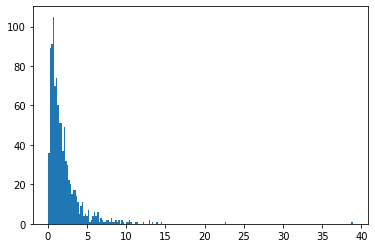

Uptime: AIRVEYOR


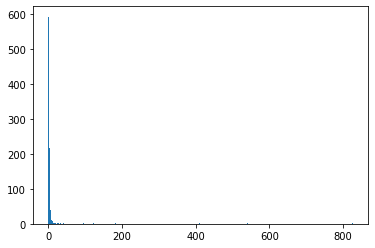

Downtime: BAD FACTORY TAG SPLICE


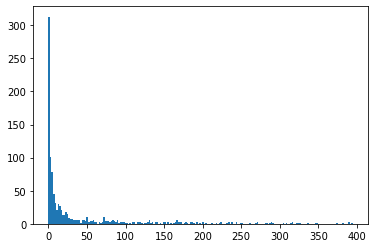

Uptime: BAD FACTORY TAG SPLICE


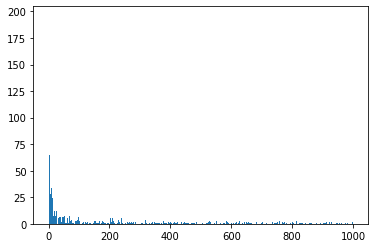

Downtime: CARTON FEEDER


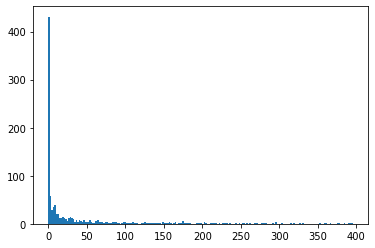

Uptime: CARTON FEEDER


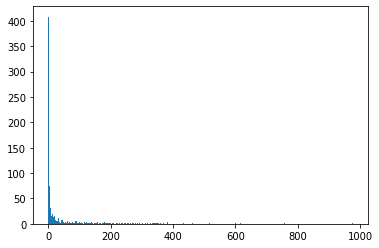

Downtime: CLEAN


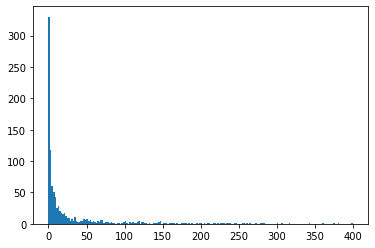

Uptime: CLEAN


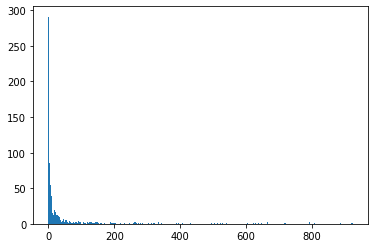

Downtime: DAILY MAINTENANCE


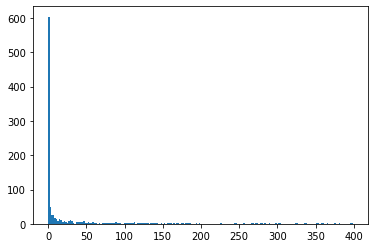

Uptime: DAILY MAINTENANCE


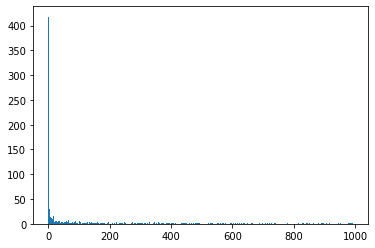

Downtime: EXIT CONVEYOR JAM


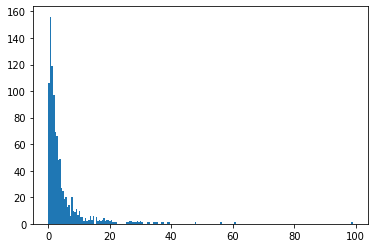

Uptime: EXIT CONVEYOR JAM


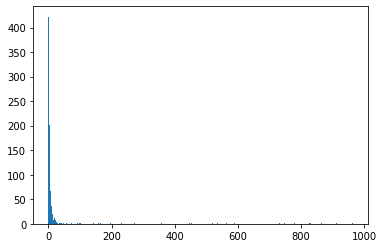

Downtime: FOIL


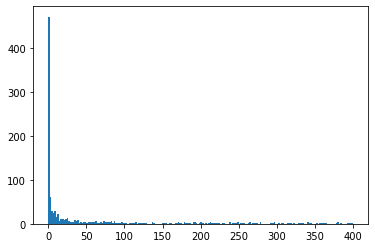

Uptime: FOIL


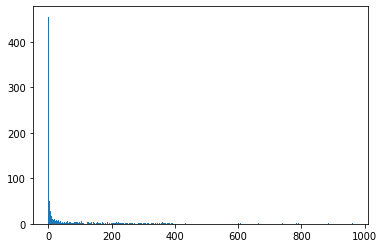

Downtime: GUNBELT


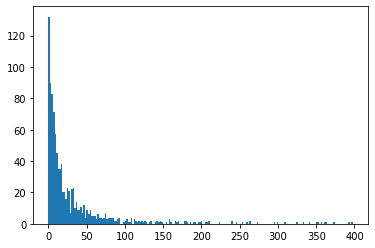

Uptime: GUNBELT


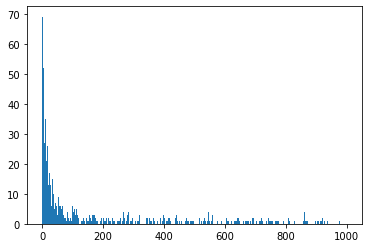

Downtime: JAM


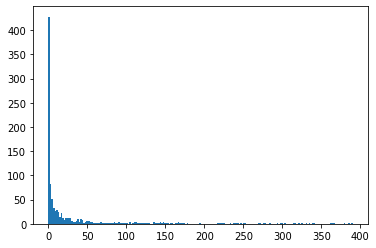

Uptime: JAM


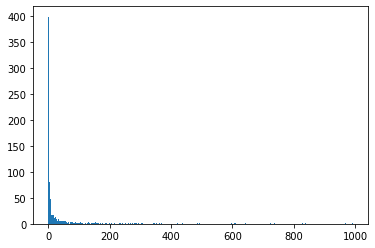

Downtime: LOOSE


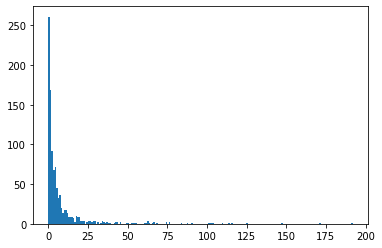

Uptime: LOOSE


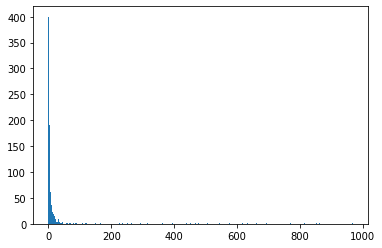

Downtime: MUTIPLE TAILS


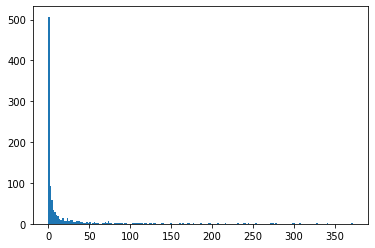

Uptime: MUTIPLE TAILS


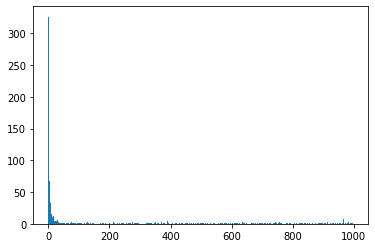

Downtime: OPERATOR ERROR


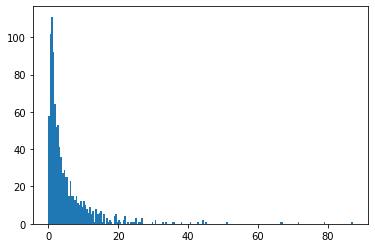

Uptime: OPERATOR ERROR


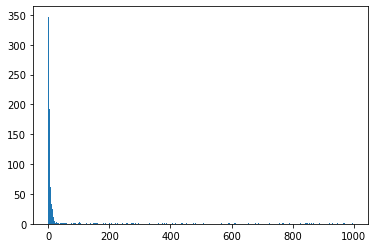

Downtime: OTHER


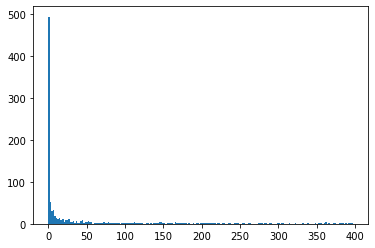

Uptime: OTHER


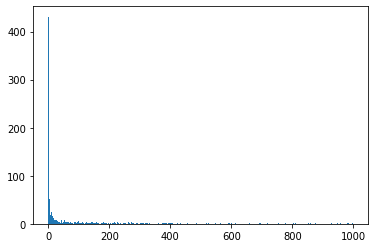

Downtime: OVERHEAD SWEEP JAM


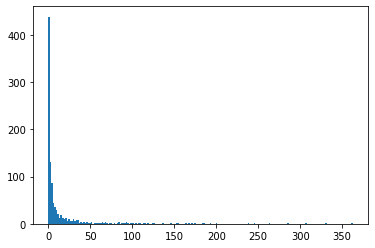

Uptime: OVERHEAD SWEEP JAM


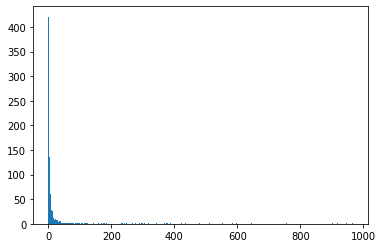

Downtime: PAPER


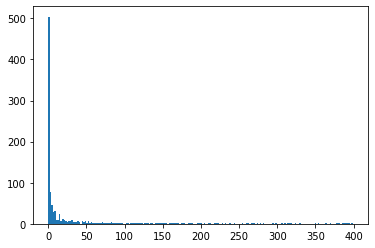

Uptime: PAPER


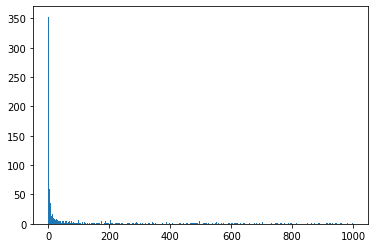

Downtime: PHOTO EYE


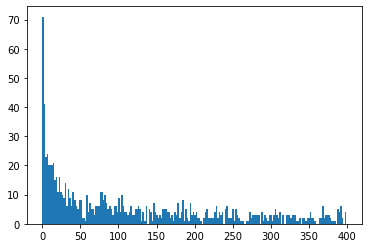

Uptime: PHOTO EYE


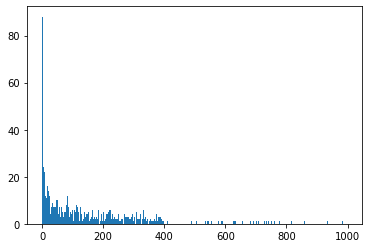

Downtime: POWER OUTAGE


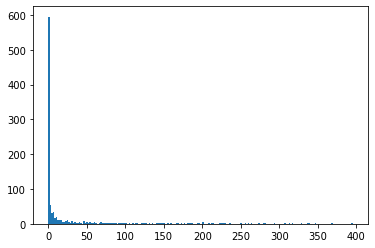

Uptime: POWER OUTAGE


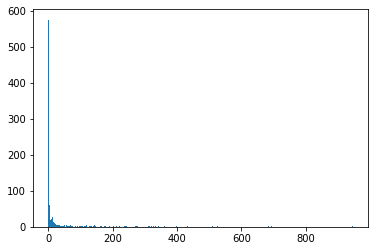

Downtime: RETIME LUG BELTS


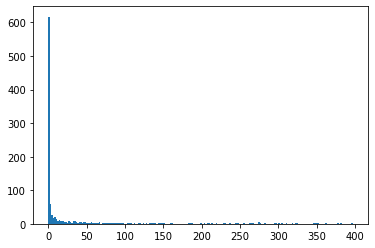

Uptime: RETIME LUG BELTS


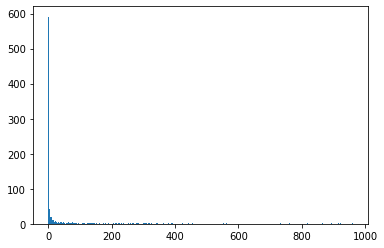

Downtime: SHINGLING


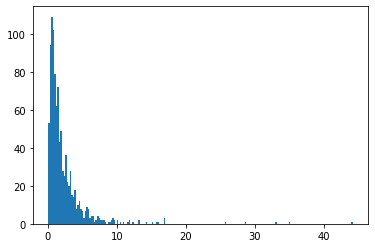

Uptime: SHINGLING


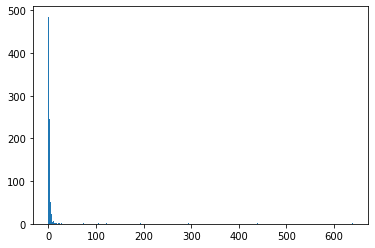

Downtime: SPLICE


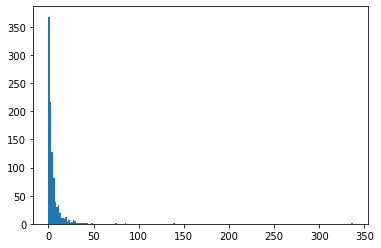

Uptime: SPLICE


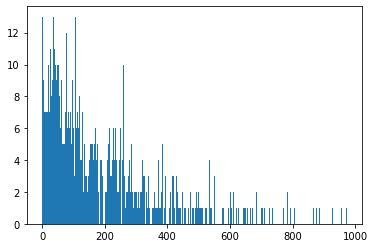

Downtime: STRING BROKE


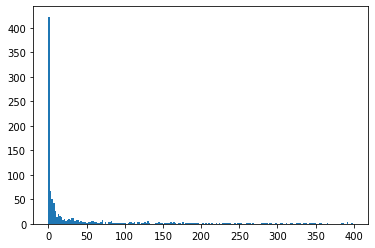

Uptime: STRING BROKE


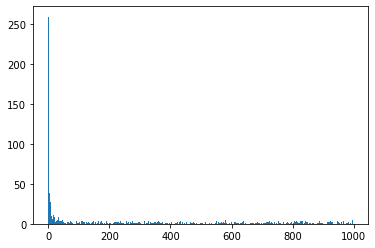

Downtime: TAG SPLICE KICKED OUT


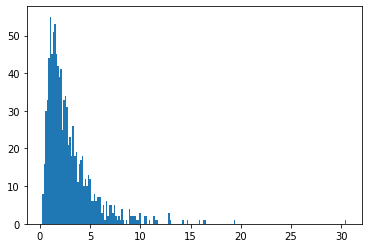

Uptime: TAG SPLICE KICKED OUT


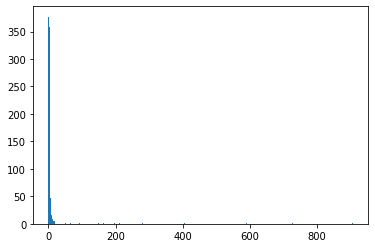

Downtime: TAGS DROPPING


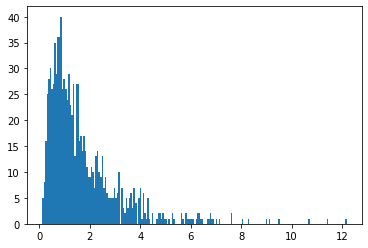

Uptime: TAGS DROPPING


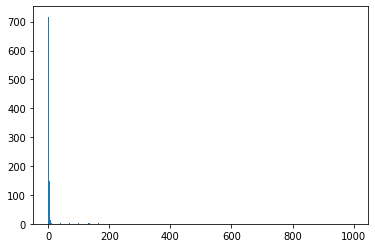

Downtime: THUMPER - MISPLACED BAG


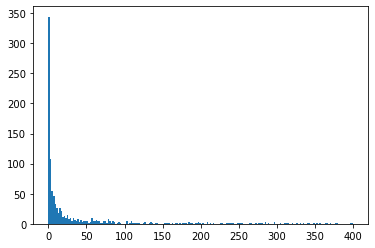

Uptime: THUMPER - MISPLACED BAG


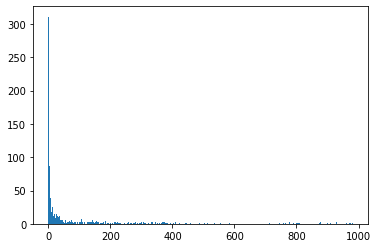

Downtime: VACUUM OUT DRUM


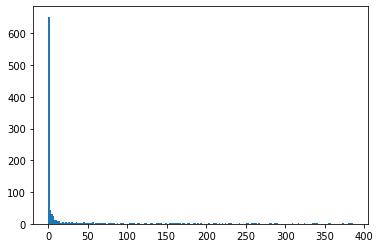

Uptime: VACUUM OUT DRUM


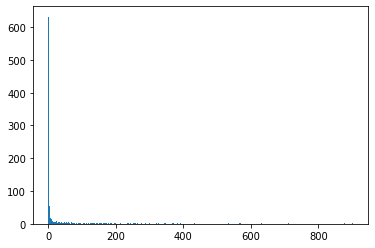

In [ ]:
# store the random numbers in a list 
nums = [] 
for failure in failure_dictionary:
    for i in range(1000): 
        temp = calculate_time(failure_dictionary[failure]["Distrib (SDT)"], 
                                failure_dictionary[failure]["Param1 (SDT)"], 
                                failure_dictionary[failure]["Param2 (SDT)"])
        while temp > 1000:
            temp = calculate_time(failure_dictionary[failure]["Distrib (SDT)"], 
                                failure_dictionary[failure]["Param1 (SDT)"], 
                                failure_dictionary[failure]["Param2 (SDT)"])
        nums.append(temp)

    # plotting a graph 
    print("Downtime: " + failure)
    plt.hist(nums, bins = 200) 
    plt.show()

    nums = []
    for i in range(1000): 
        temp = calculate_time(failure_dictionary[failure]["Distrib (UT)"], 
                                failure_dictionary[failure]["Param1 (UT)"], 
                                failure_dictionary[failure]["Param2 (UT)"])
        while temp > 1000:
            temp = calculate_time(failure_dictionary[failure]["Distrib (SDT)"], 
                                failure_dictionary[failure]["Param1 (SDT)"], 
                                failure_dictionary[failure]["Param2 (SDT)"])
        nums.append(temp)

    # plotting a graph 
    print("Uptime: " + failure)
    plt.hist(nums, bins = 500) 
    plt.show()
    nums = []


# Data Cleaning

In [812]:
df = pd.read_excel("RT Simulation Data Cleaning And Mapping - Cartoner raw data.xlsx", sheet_name=0)

c:\Users\limpert.ll\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [813]:
df = df.rename(columns={'DURATION' : 'DT'})
df['DT'] = df['DT'].astype('float')

In [814]:
df['START_TIME'] = pd.to_datetime(df['START_TIME'])

In [815]:
df = df.sort_values(by='START_TIME', ascending=True)

In [817]:
df['UT'] = df['START_TIME'].diff().apply(lambda x: x/np.timedelta64(1, 'm')).fillna(-1)

In [818]:
df

,START_TIME,AUTO_CAUSE,LINE #,DT,REASON,CAUSE,OPERATOR_COMMENT,UT
0,1998-03-01 15:00:01,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,479.95,Inventory Ctrl,Scheduled Down,,-1.000000
1,1998-03-01 22:59:58,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,26.41,Inventory Ctrl,Team Meeting,,479.950000
2,1998-03-01 23:30:57,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,7.48,Clean Up,Clean Cross Seal,CLEANED-LUBED-X-SEAL ROLLS-CONT SEAL ROLLS,30.983333
3,1998-03-01 23:39:01,CYCLE STOP @ PANELVIEW,PACKING L1,1.35,Clean Up,Cleaned A Backslide,BACKSLIDE SWA RETURNING SLOWLY,8.066667
4,1998-03-01 23:41:03,CYCLE STOP @ PANELVIEW,PACKING L1,1.12,Clean Up,Cleaned A Backslide,BACKSLIDE SWA RETURNING SLOWLY,2.033333
...,...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,Unknown/Unassigned Cause,PACKING L1,1.80,Operational,Gunbelt - Drop,,3.300000
525,1998-04-01 04:13:40,Unknown/Unassigned Cause,PACKING L1,1.40,Operational,Tag Cut Walked Off,,1.800000
526,1998-04-01 04:15:04,Unknown/Unassigned Cause,PACKING L1,1.77,Operational,Gunbelt - Drop,Turned o-ring around,1.400000
527,1998-04-01 04:16:56,LANGEN CLUTCH OVERLOAD,PACKING L1,3.15,Operational,Jam at Sample Station,Foil web walked out REAL UGLY!!!!!!!!!!,1.866667


In [819]:
df['UT'] = df['UT'] - df['DT'].shift(1)

In [820]:
df['UT'] = df['UT'].fillna(-1)

In [821]:
cols = ['START_TIME', 'UT', 'DT', 'CAUSE', 'AUTO_CAUSE', 'LINE #', 'REASON']

In [822]:
df = df[cols]

In [860]:
UT_dropped = df.loc[(df['UT'] < 0)]

In [861]:
df2 = df.loc[(df['UT'] >= 0)]

In [862]:
UT_dropped

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON
0,1998-03-01 15:00:01,-1.000000,479.95,Scheduled Down,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
150,1998-03-07 23:00:02,-0.003333,479.94,Scheduled Down,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
213,1998-03-12 06:59:56,-0.006667,18.80,Team Meeting,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
246,1998-03-14 06:59:56,-0.010000,480.07,Scheduled Down,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
248,1998-03-14 22:59:58,-0.006667,479.98,Scheduled Down,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
251,1998-03-15 22:59:58,-0.003333,12.46,Team Meeting,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
328,1998-03-21 06:59:56,-0.003333,480.09,Scheduled Down,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
356,1998-03-23 23:41:17,-0.013333,8.70,Daily Maintenance,Unknown/Unassigned Cause,PACKING L1,Maintenance
458,1998-03-26 15:00:02,-0.006667,479.95,Scheduled Down,LANGEN CLUTCH OVERLOAD,PACKING L1,Inventory Ctrl
462,1998-03-27 22:59:57,-0.013333,479.98,Scheduled Down,LANGEN CLUTCH OVERLOAD,PACKING L1,Inventory Ctrl


In [863]:
DT_dropped = df2.loc[(df['DT'] < 0)]

In [864]:
DT_dropped

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON


In [865]:
df2 = df2.loc[(df['DT'] >= 0)]

In [866]:
df2

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON
1,1998-03-01 22:59:58,0.000000,26.41,Team Meeting,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl
2,1998-03-01 23:30:57,4.573333,7.48,Clean Cross Seal,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up
3,1998-03-01 23:39:01,0.586667,1.35,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up
4,1998-03-01 23:41:03,0.683333,1.12,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up
5,1998-03-01 23:44:23,2.213333,3.11,Cleaned A Backslide,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up
...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,0.000000,1.80,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational
525,1998-04-01 04:13:40,0.000000,1.40,Tag Cut Walked Off,Unknown/Unassigned Cause,PACKING L1,Operational
526,1998-04-01 04:15:04,0.000000,1.77,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational
527,1998-04-01 04:16:56,0.096667,3.15,Jam at Sample Station,LANGEN CLUTCH OVERLOAD,PACKING L1,Operational


In [867]:
# Abnormal Value check Downtime
for cause in df2['CAUSE'].unique():
    mean = df2['DT'].loc[df2['CAUSE'] == cause].mean()
    std = df2['DT'].loc[df2['CAUSE'] == cause].std()
    df2['Abnormal DT'] = df2['DT'].apply(lambda x: x >= (mean + (2 * std)))
    df2['Abnormal DT'] = df2['DT'].apply(lambda x: x <= (mean - (2 * std)))
df2

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON,Abnormal DT
1,1998-03-01 22:59:58,0.000000,26.41,Team Meeting,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl,False
2,1998-03-01 23:30:57,4.573333,7.48,Clean Cross Seal,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up,False
3,1998-03-01 23:39:01,0.586667,1.35,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False
4,1998-03-01 23:41:03,0.683333,1.12,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False
5,1998-03-01 23:44:23,2.213333,3.11,Cleaned A Backslide,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up,False
...,...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,0.000000,1.80,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False
525,1998-04-01 04:13:40,0.000000,1.40,Tag Cut Walked Off,Unknown/Unassigned Cause,PACKING L1,Operational,False
526,1998-04-01 04:15:04,0.000000,1.77,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False
527,1998-04-01 04:16:56,0.096667,3.15,Jam at Sample Station,LANGEN CLUTCH OVERLOAD,PACKING L1,Operational,False


In [868]:
df2.loc[df2['Abnormal DT'] == False]

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON,Abnormal DT
1,1998-03-01 22:59:58,0.000000,26.41,Team Meeting,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl,False
2,1998-03-01 23:30:57,4.573333,7.48,Clean Cross Seal,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up,False
3,1998-03-01 23:39:01,0.586667,1.35,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False
4,1998-03-01 23:41:03,0.683333,1.12,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False
5,1998-03-01 23:44:23,2.213333,3.11,Cleaned A Backslide,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up,False
...,...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,0.000000,1.80,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False
525,1998-04-01 04:13:40,0.000000,1.40,Tag Cut Walked Off,Unknown/Unassigned Cause,PACKING L1,Operational,False
526,1998-04-01 04:15:04,0.000000,1.77,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False
527,1998-04-01 04:16:56,0.096667,3.15,Jam at Sample Station,LANGEN CLUTCH OVERLOAD,PACKING L1,Operational,False


In [869]:
# Abnormal Value check Uptime
for cause in df2['CAUSE'].unique():
    mean = df2['UT'].loc[df2['CAUSE'] == cause].mean()
    std = df2['UT'].loc[df2['CAUSE'] == cause].std()
    df2['Abnormal UT'] = df2['UT'].apply(lambda x: x >= (mean + (2 * std)))
    df2['Abnormal UT'] = df2['UT'].apply(lambda x: x <= (mean - (2 * std)))
df2

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON,Abnormal DT,Abnormal UT
1,1998-03-01 22:59:58,0.000000,26.41,Team Meeting,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl,False,False
2,1998-03-01 23:30:57,4.573333,7.48,Clean Cross Seal,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up,False,False
3,1998-03-01 23:39:01,0.586667,1.35,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
4,1998-03-01 23:41:03,0.683333,1.12,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
5,1998-03-01 23:44:23,2.213333,3.11,Cleaned A Backslide,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up,False,False
...,...,...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,0.000000,1.80,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
525,1998-04-01 04:13:40,0.000000,1.40,Tag Cut Walked Off,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
526,1998-04-01 04:15:04,0.000000,1.77,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
527,1998-04-01 04:16:56,0.096667,3.15,Jam at Sample Station,LANGEN CLUTCH OVERLOAD,PACKING L1,Operational,False,False


In [870]:
df2.loc[df2['Abnormal UT'] == False]

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON,Abnormal DT,Abnormal UT
1,1998-03-01 22:59:58,0.000000,26.41,Team Meeting,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Inventory Ctrl,False,False
2,1998-03-01 23:30:57,4.573333,7.48,Clean Cross Seal,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up,False,False
3,1998-03-01 23:39:01,0.586667,1.35,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
4,1998-03-01 23:41:03,0.683333,1.12,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
5,1998-03-01 23:44:23,2.213333,3.11,Cleaned A Backslide,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up,False,False
...,...,...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,0.000000,1.80,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
525,1998-04-01 04:13:40,0.000000,1.40,Tag Cut Walked Off,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
526,1998-04-01 04:15:04,0.000000,1.77,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
527,1998-04-01 04:16:56,0.096667,3.15,Jam at Sample Station,LANGEN CLUTCH OVERLOAD,PACKING L1,Operational,False,False


In [871]:
df2['REASON'].unique()

array(['Inventory Ctrl', 'Clean Up', 'Operational', 'Packing Material',
       'Maintenance', 'Electrical', 'Adjustment', 'Mechanical',
       'Raw Material'], dtype=object)

In [872]:
reason_parse = ['Clean Up', 'Operational', 'Packing Material',
       'Maintenance', 'Electrical', 'Adjustment', 'Mechanical',
       'Raw Material']

In [873]:
df3 = df2.loc[~(df2['REASON'].isin(reason_parse))]

In [874]:
df2 = df2.loc[df2['REASON'].isin(reason_parse)]

In [875]:
df2

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON,Abnormal DT,Abnormal UT
2,1998-03-01 23:30:57,4.573333,7.48,Clean Cross Seal,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up,False,False
3,1998-03-01 23:39:01,0.586667,1.35,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
4,1998-03-01 23:41:03,0.683333,1.12,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
5,1998-03-01 23:44:23,2.213333,3.11,Cleaned A Backslide,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up,False,False
6,1998-03-02 00:00:56,13.440000,1.36,Splice - Foil,IN-PHASE STOP UNWIND FOIL,PACKING L1,Operational,False,False
...,...,...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,0.000000,1.80,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
525,1998-04-01 04:13:40,0.000000,1.40,Tag Cut Walked Off,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
526,1998-04-01 04:15:04,0.000000,1.77,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
527,1998-04-01 04:16:56,0.096667,3.15,Jam at Sample Station,LANGEN CLUTCH OVERLOAD,PACKING L1,Operational,False,False


In [876]:
df2 = df2.loc[~(df2['CAUSE'].str.contains(r"Changeover", case=False))]

In [877]:
df2

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON,Abnormal DT,Abnormal UT
2,1998-03-01 23:30:57,4.573333,7.48,Clean Cross Seal,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up,False,False
3,1998-03-01 23:39:01,0.586667,1.35,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
4,1998-03-01 23:41:03,0.683333,1.12,Cleaned A Backslide,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
5,1998-03-01 23:44:23,2.213333,3.11,Cleaned A Backslide,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up,False,False
6,1998-03-02 00:00:56,13.440000,1.36,Splice - Foil,IN-PHASE STOP UNWIND FOIL,PACKING L1,Operational,False,False
...,...,...,...,...,...,...,...,...,...
524,1998-04-01 04:11:52,0.000000,1.80,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
525,1998-04-01 04:13:40,0.000000,1.40,Tag Cut Walked Off,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
526,1998-04-01 04:15:04,0.000000,1.77,Gunbelt - Drop,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
527,1998-04-01 04:16:56,0.096667,3.15,Jam at Sample Station,LANGEN CLUTCH OVERLOAD,PACKING L1,Operational,False,False


In [879]:
df2['CAUSE'] = df2['CAUSE'].apply(lambda x: "SPLICE" if "splice" in x.lower() else x)
df2['CAUSE'] = df2['CAUSE'].apply(lambda x: "CLEAN" if "clean" in x.lower() else x)
df2['CAUSE'] = df2['CAUSE'].apply(lambda x: "GUNBELT" if "gunbelt" in x.lower() else x)

df2 = df2.loc[df2['CAUSE'].isin(['SPLICE', 'CLEAN', 'GUNBELT'])]


In [880]:
df2

,START_TIME,UT,DT,CAUSE,AUTO_CAUSE,LINE #,REASON,Abnormal DT,Abnormal UT
2,1998-03-01 23:30:57,4.573333,7.48,CLEAN,IN-PHASE STOP BUTTON @ SWING A,PACKING L1,Clean Up,False,False
3,1998-03-01 23:39:01,0.586667,1.35,CLEAN,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
4,1998-03-01 23:41:03,0.683333,1.12,CLEAN,CYCLE STOP @ PANELVIEW,PACKING L1,Clean Up,False,False
5,1998-03-01 23:44:23,2.213333,3.11,CLEAN,STOP BUTTON @ LANGEN GEAR SIDE,PACKING L1,Clean Up,False,False
6,1998-03-02 00:00:56,13.440000,1.36,SPLICE,IN-PHASE STOP UNWIND FOIL,PACKING L1,Operational,False,False
...,...,...,...,...,...,...,...,...,...
521,1998-04-01 03:20:28,0.126667,0.39,SPLICE,2 OF 400 TAGS MISSING @ TURRET,PACKING L1,Operational,False,False
522,1998-04-01 04:07:08,46.276667,0.79,GUNBELT,GUN BELT DROP,PACKING L1,Operational,False,False
524,1998-04-01 04:11:52,0.000000,1.80,GUNBELT,Unknown/Unassigned Cause,PACKING L1,Operational,False,False
526,1998-04-01 04:15:04,0.000000,1.77,GUNBELT,Unknown/Unassigned Cause,PACKING L1,Operational,False,False


# Fitting Weibull

In [960]:
data = (df2.loc[df2['CAUSE'] == 'CLEAN'])['UT']

In [961]:
data

2        4.573333
3        0.586667
4        0.683333
5        2.213333
27       0.000000
65       3.116667
186    103.846667
187      2.993333
310      2.416667
319     62.733333
Name: UT, dtype: float64

In [955]:
weibull_min.fit(data, loc=0)

(0.33230281019423424, -6.415302973053979e-30, 11.928546767613238)

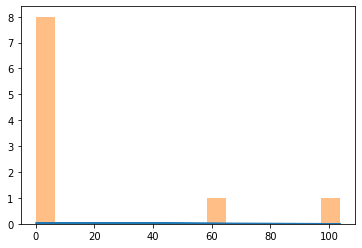

In [954]:
plt.plot(data, weibull_min.pdf(data, *weibull_min.fit(data, floc=0)))
_ = plt.hist(data, bins=16, alpha=0.5);
plt.show()